### Generate data

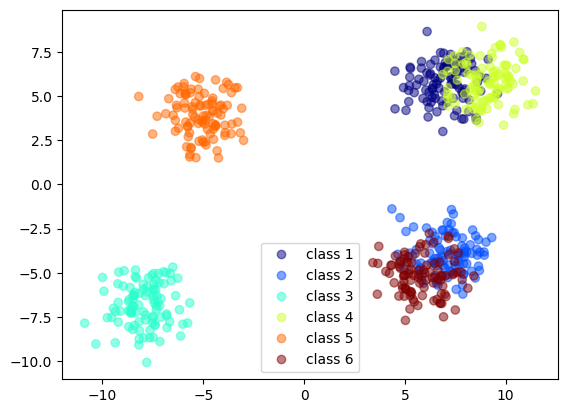

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from utils import generate_clusters, plot

k = 6
df = generate_clusters(k, sd=1.1)
labels = [f"class {i+1}" for i in range(k)]

# Plot true clusters
plot(df, labels)

### K-means Algorithm

In [37]:
def distance(A: np.array, B: np.array, p: int = 2):
    """Calculates the distance between two points using Euclidean distance"""
    return np.sqrt(np.sum((A - B)**p))

def random_centroids(df, k):
    """Picks k random points to be the centroids"""
    indices = [np.random.randint(0, len(df)) for _ in range(k)]
    return np.array([np.array([df.x[i], df.y[i]]) for i in indices])

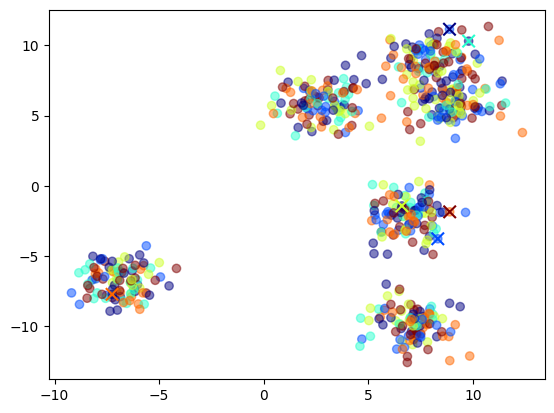

In [56]:
size = len(df)

# Select K points as the initial centroids
centroids = random_centroids(df, k)

# Step 1: randomly assign each point to a centroid
df["cluster"] = np.random.randint(0, k, size)

plt.scatter(df.x, df.y, c=df.cluster, cmap=cm.jet, alpha=0.5)
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=80, c=range(k), cmap=cm.jet)

In [57]:
# Step 2: Continuously adjust centroids and update clusters
def kmeans(df, centroids, max_iter: int = 100):
    data = df.copy()
    k = len(centroids)

    for _ in range(max_iter):

        # Re-assign all points to nearest cluster
        for i in range(size):
            row = data.iloc[i]
            # Get point
            point = np.array([row.x, row.y])
            # Calculate distance to each centroid
            closest_cluster = np.argmin(
                [distance(point, centroids[i]) for i in range(k)]
            )
            # Assign to closest cluster
            data.at[i, "cluster"] = closest_cluster

        # Update centroids
        for i in range(k):
            cluster = data[data.cluster == i]

            # Only update the centroid if there are points in it
            if len(cluster) == 0:
                continue

            centroids[i] = np.array([cluster.x.mean(), cluster.y.mean()])

    return centroids, data

centroids, data = kmeans(df, centroids)

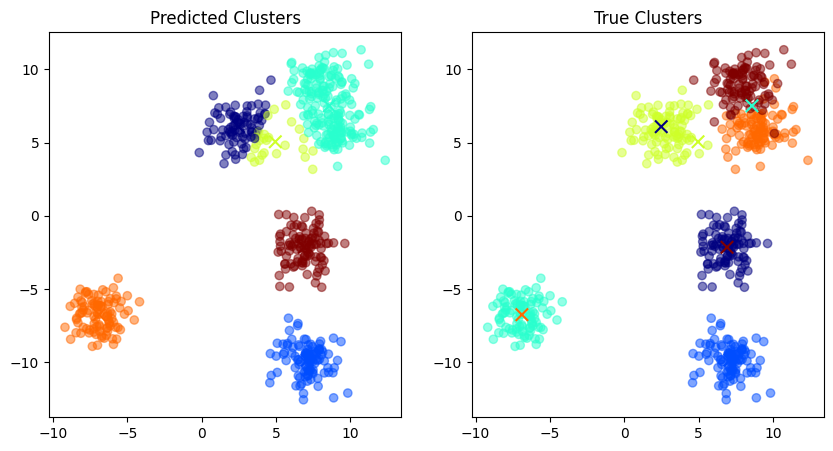

In [58]:
# Side by side comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(data.x, data.y, c=data.cluster, cmap=cm.jet, alpha=0.5)
axs[0].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=80, c=range(k), cmap=cm.jet)
axs[0].set_title("Predicted Clusters")

axs[1].set_title("True Clusters")
axs[1].scatter(data.x, data.y, c=data.label, cmap=cm.jet, alpha=0.5)
axs[1].scatter(centroids[:, 0], centroids[:, 1], marker='x', s=80, c=range(k), cmap=cm.jet)

## Variations of K-means Algorithm

### Method 1: Using SSE (Sum of Squared Errors)

In [60]:
import math

def using_sse(k, df, iter=50):
    """
    Run k-means a number of times and select the clusters
    with the lowest Sum of Squared Errors (SSE).
    """
    best_centroids = None
    best_sse = math.inf
    for _ in range(iter):
        intial_centroids = random_centroids(df, k)
        tuned_centroids, data = kmeans(df, intial_centroids, max_iter=25)

        sse = 0
        for i, c in enumerate(tuned_centroids):
            points = data[data.cluster == i]
            sse += np.sum([distance(c, [row.x, row.y])**2 for _, row in points.iterrows()])

        if sse < best_sse:
            best_sse = sse
            best_centroids = intial_centroids

    return best_centroids

df = generate_clusters(k, sd=1.1)
df["cluster"] = np.random.randint(0, k, size)
best_centroids = using_sse(k, df)
best_centroids

array([[ 3.79532159,  3.17433701],
       [-4.92520434, -3.20252968],
       [-1.85245131,  8.80768342],
       [-5.87451982,  6.98096204],
       [-1.8024672 ,  1.10132662],
       [-4.23120245,  9.40945016]])

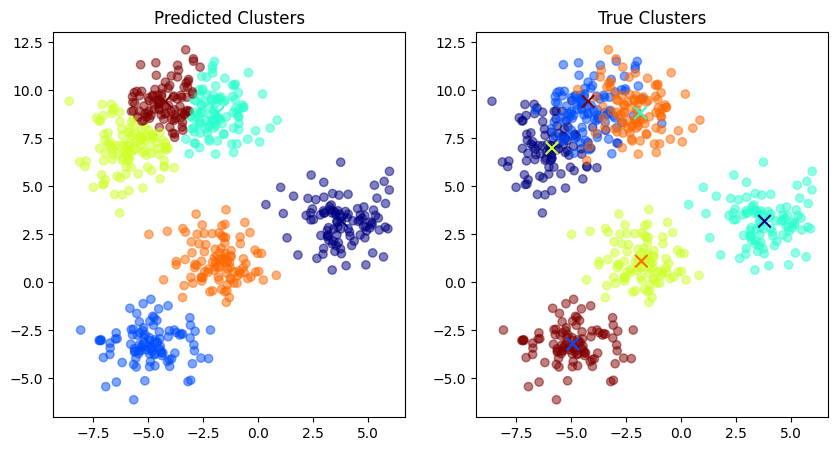

In [62]:
centroids, data = kmeans(df, best_centroids)

# Side by side comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(data.x, data.y, c=data.cluster, cmap=cm.jet, alpha=0.5)
axs[0].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=80, c=range(k), cmap=cm.jet
)
axs[0].set_title("Predicted Clusters")

axs[1].set_title("True Clusters")
axs[1].scatter(data.x, data.y, c=data.label, cmap=cm.jet, alpha=0.5)
axs[1].scatter(
    centroids[:, 0], centroids[:, 1], marker="x", s=80, c=range(k), cmap=cm.jet
)

### Method 2: Using K-means++

In [78]:
def kpp_centroids(df, k):
    centroids = []
    for i in range(k):
        # The first centroid is randomly selected
        if i == 0:
            random_index = np.random.randint(0, len(df))
            centroids.append(
                np.array(
                    [
                        df.iloc[random_index].x,
                        df.iloc[random_index].y,
                    ]
                )
            )
            continue

        # Calculate distances of each point from its closest centroid
        distances = []
        for _, row in df.iterrows():
            # Calculate distance of the point between each centroid and 
            # select the distance which is smaller, representing the
            # distance between the closest centroid.
            d = min([distance(c, np.array([row.x, row.y])) ** 2 for c in centroids])
            distances.append(d)

        # Convert to probabilties
        probabilities = distances / np.sum(distances)

        # Random selection
        index = np.random.choice(range(len(df)), p=probabilities)
        row = df.iloc[index]
        centroids.append([row.x, row.y])

    return centroids


df = generate_clusters(k, sd=1.1)
df["cluster"] = np.random.randint(0, k, size)
centroids = kpp_centroids(df, k)

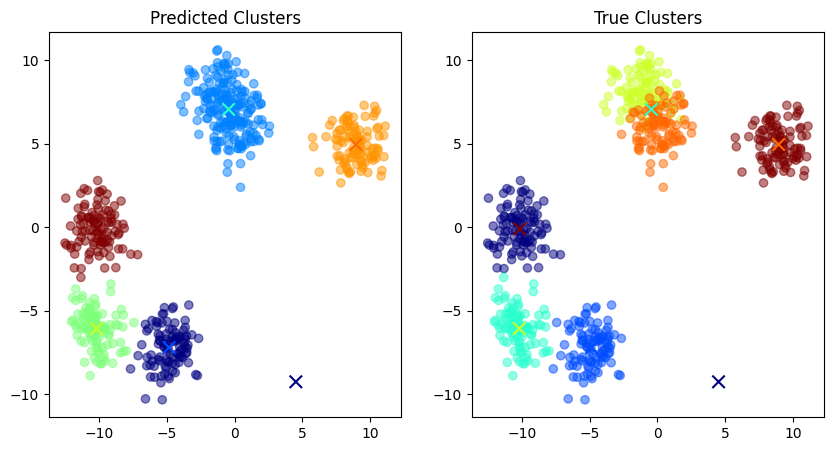

In [79]:
tuned_centroids, data = kmeans(df, best_centroids)

# Side by side comparison
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].scatter(data.x, data.y, c=data.cluster, cmap=cm.jet, alpha=0.5)
axs[0].scatter(
    tuned_centroids[:, 0], tuned_centroids[:, 1], marker="x", s=80, c=range(k), cmap=cm.jet
)
axs[0].set_title("Predicted Clusters")

axs[1].set_title("True Clusters")
axs[1].scatter(data.x, data.y, c=data.label, cmap=cm.jet, alpha=0.5)
axs[1].scatter(
    tuned_centroids[:, 0], tuned_centroids[:, 1], marker="x", s=80, c=range(k), cmap=cm.jet
)